Original shape: (303, 14)
After dropping duplicates: (302, 14)
Accuracy: 0.8360655737704918

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



C:\Users\Eslam\AppData\Local\Temp\ipykernel_75404\3065376402.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\Eslam\AppData\Local\Temp\ipykernel_75404\3065376402.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

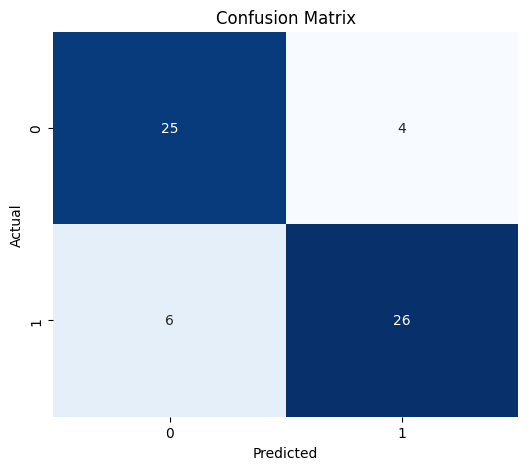

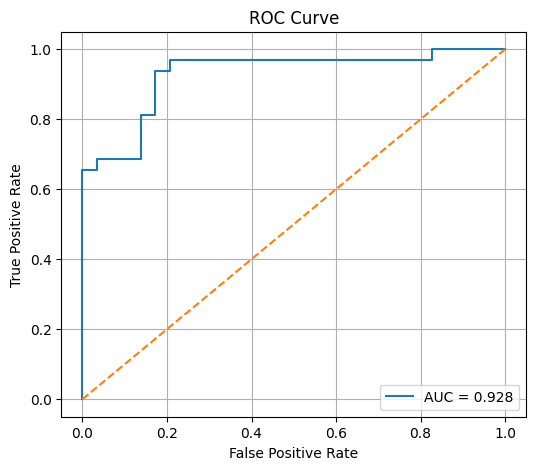

AUC Score: 0.9278017241379312


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Load dataset and remove duplicates
# ---------------------------
df = pd.read_csv("./DataSets/heart.csv")
print("Original shape:", df.shape)
df.drop_duplicates(inplace=True)
print("After dropping duplicates:", df.shape)

# ---------------------------
# 2. Outlier handling (replace outliers with NaN)
# ---------------------------
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def replace_outliers_with_nulls(data, columns):
    df_copy = data.copy()
    for col in columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        df_copy.loc[(df_copy[col] < lower_limit) | (df_copy[col] > upper_limit), col] = np.nan
    return df_copy

df = replace_outliers_with_nulls(df, numeric_cols)

# Fill numeric with mean
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill categorical with mode
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ---------------------------
# 3. Manual medical discretization
# ---------------------------
# Age
def age_bin(age):
    if age < 30: return 0
    elif age < 40: return 1
    elif age < 50: return 2
    elif age < 60: return 3
    else: return 4
df['age_bin'] = df['age'].apply(age_bin)

# Blood pressure (trestbps)
def bp_bin(bp):
    if bp < 120: return 0
    elif bp < 130: return 1
    elif bp < 140: return 2
    elif bp < 160: return 3
    else: return 4
df['bp_bin'] = df['trestbps'].apply(bp_bin)

# Cholesterol
def chol_bin(chol):
    if chol < 200: return 0
    elif chol < 240: return 1
    else: return 2
df['chol_bin'] = df['chol'].apply(chol_bin)

# You can add more bins for 'thalach' or 'oldpeak' if desired

# ---------------------------
# 4. Prepare final dataset
# ---------------------------
final_features = categorical_cols + ['age_bin', 'bp_bin', 'chol_bin']
X = df[final_features].astype(int)
y = df['target'].astype(int)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# 5. Train Categorical Naive Bayes
# ---------------------------
model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probability for class 1 (adjust if needed)

# ---------------------------
# 6. Evaluation
# ---------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
print("AUC Score:", roc_auc)
